# Course 2: Advanced Portfolio Construction and Analysis With Python
## Module 4: Portfolio Optimization in Practice

**Question 1**

Load the 49 Value Weighted industry portfolio returns. Limit the analysis to returns of the 49 VW portfolios from the most recent 5 years for which you have data i.e 2014-2018 both years inclusive. Also load the Market Caps of each of the 49 industries. Assume that the cap-weights as of the first month (2014-01) are the cap-weights we’ll use for this analysis.

Which Industry had the highest risk contribution in the cap-weighted portfolio?

Enter your answer as text, exactly as they are named in the Data file (i.e. Hlth, Fin, Whlsl, Rtail, or Food)

In [1]:
import pandas as pd
import numpy as np

In [2]:
def get_ind_file(filetype, weighting="vw", n_inds=30):
    """
    Load and format the Ken French Industry Portfolios files
    Variant is a tuple of (weighting, size) where:
        weighting is one of "ew", "vw"
        number of inds is 30 or 49
    """    
    if filetype is "returns":
        name = f"{weighting}_rets" 
        divisor = 100
    elif filetype is "nfirms":
        name = "nfirms"
        divisor = 1
    elif filetype is "size":
        name = "size"
        divisor = 1
    else:
        raise ValueError(f"filetype must be one of: returns, nfirms, size")
    
    ind = pd.read_csv(f"data/ind{n_inds}_m_{name}.csv", header=0, index_col=0, na_values=-99.99)/divisor
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind

def get_ind_market_caps(n_inds=30, weights=False):
    """
    Load the industry portfolio data and derive the market caps
    """
    ind_nfirms = get_ind_file('nfirms', n_inds=n_inds)
    ind_size =get_ind_file('size', n_inds=n_inds)
    ind_mktcap = ind_nfirms * ind_size
    if weights:
        total_mktcap = ind_mktcap.sum(axis=1)
        ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")
        return ind_capweight
    return ind_mktcap

In [3]:
ind_returns =  get_ind_file('returns', 'vw', n_inds=49).loc['2014':'2018',:]        
weights = get_ind_market_caps(n_inds=49, weights=True).loc['2014':'2018',:]

In [4]:
def risk_contribution(w,cov):
    """
    Compute the contributions to risk of the constituents of a portfolio, given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_var = w.T @ cov @ w
    # Marginal contribution of each constituent
    marginal_contrib = cov@w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return risk_contrib

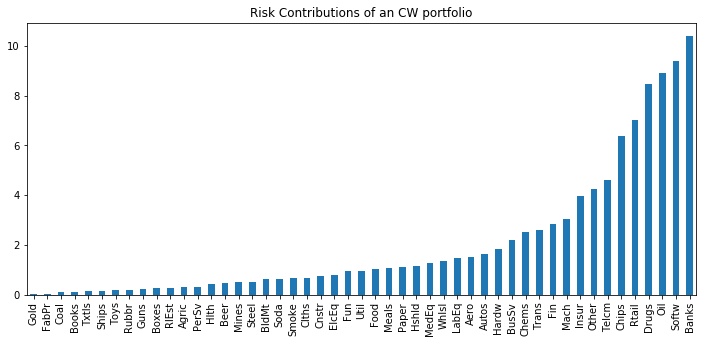

In [5]:
risks_cw = risk_contribution(weights.iloc[0,:], ind_returns.cov())*100
risks_cw.sort_values().plot.bar(title="Risk Contributions of an CW portfolio", figsize = (12,5))

In [6]:
risks_cw.idxmax()

'Banks'

**Question 2**

Use the same data as the previous question. What was the highest risk contribution from any one industry in the cap-weighted portfolio?

Enter the answer as a percentage (e.g. for 5.67% enter 5.67)

In [7]:
round(risks_cw.max(),2)

10.41

**Question 3**

Use the same data set as the previous question.

Which Industry had the highest risk contribution in the equal-weighted portfolio?

Enter your answer as text, exactly as they are named in the Data file (i.e. Hlth, Fin, Whlsl, Rtail, or Food)

In [8]:
def weight_ew(r, cap_weights=None, max_cw_mult=None, microcap_threshold=None, **kwargs):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    If supplied a set of capweights and a capweight tether, it is applied and reweighted 
    """
    n = len(r.columns)
    ew = pd.Series(1/n, index=r.columns)
    if cap_weights is not None:
        cw = cap_weights.loc[r.index[0]] # starting cap weight
        ## exclude microcaps
        if microcap_threshold is not None and microcap_threshold > 0:
            microcap = cw < microcap_threshold
            ew[microcap] = 0
            ew = ew/ew.sum()
        #limit weight to a multiple of capweight
        if max_cw_mult is not None and max_cw_mult > 0:
            ew = np.minimum(ew, cw*max_cw_mult)
            ew = ew/ew.sum() #reweight
    return ew

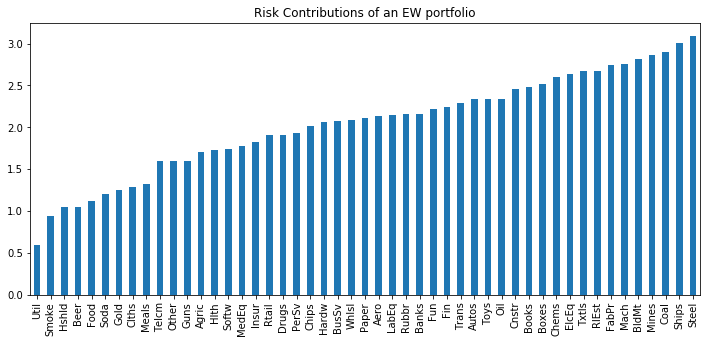

In [9]:
risks_ew = risk_contribution(weight_ew(ind_returns), ind_returns.cov())*100
risks_ew.sort_values().plot.bar(title="Risk Contributions of an EW portfolio", figsize = (12,5))

In [10]:
risks_ew.idxmax()

'Steel'

**Question 4**

Use the same data as the previous question.

What was the highest risk contribution from any one industry in the equal-weighted portfolio?
Enter the answer as a percentage (e.g. for 5.67% enter 5.67)

In [11]:
round(risks_ew.max(),2)

3.09

**Question 5**

Using the Sample Covariance over the 5 year period, compute the weights of the ERC portfolio. What sector portfolio is assigned the highest weight in the ERC portfolio?

Enter your answer as text, exactly as they are named in the Data file (i.e. Hlth, Fin, Whlsl, Rtail, or Food)

In [12]:
from scipy.optimize import minimize

def target_risk_contributions(target_risk, cov):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)

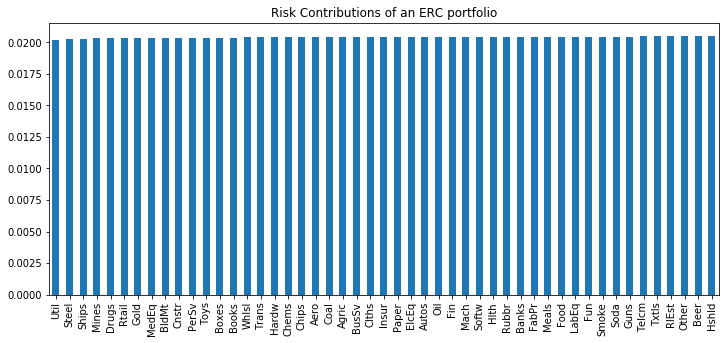

In [13]:
erc_weights = pd.Series(equal_risk_contributions(ind_returns.cov()))
erc_weights.index = ind_returns.columns
risks_erc = risk_contribution(erc_weights, ind_returns.cov())
risks_erc.sort_values().plot.bar(title="Risk Contributions of an ERC portfolio", figsize = (12,5))

In [14]:
erc_weights.idxmax()

'Util'

**Question 6**

Using the same data as the previous question (Sample Covariance over the 5 year period, and the initial capweights over that period) compute the weights of the ERC portfolio. What is the weight of the sector portfolio that is assigned the highest weight in the ERC portfolio?

Enter the answer as a percentage (e.g. for 5.67% enter 5.67)

In [15]:
round(erc_weights.max()*100,2)

5.22

**Question 7**

Use the same data as the previous question (Sample Covariance over the 5 year period, and the initial capweights over that period) and the weights of ERC portfolio. What sector portfolio is assigned the lowest weight in the ERC portfolio?

Enter your answer as text, exactly as they are named in the Data file (i.e. Hlth, Fin, Whlsl, Rtail, or Food)

In [16]:
erc_weights.idxmin()

'Steel'

**Question 8**

Use the same data as the previous question (Sample Covariance over the 5 year period, and the initial capweights over that period) and the weights of ERC portfolio.

What is the weight of the sector portfolio that is assigned the lowest weight in the ERC portfolio?

Enter the answer as a percentage (e.g. for 5.67% enter 5.67)

In [17]:
round(erc_weights.min()*100,2)

1.28

**Question 9**

Use the same data as you used in the previous question (Sample Covariance over the 5 year period and the initial capweights over that period).

In the cap-weighted portfolio what is the difference in risk contributions between the largest contributor to portfolio risk and the smallest contributor to portfolio risk?

Enter the answer as a percentage (e.g. for 5.67% enter 5.67)

In [18]:
round(risks_cw.max() - risks_cw.min(),2)

10.4

**Question 10**

Use the same data as you used in the previous question (Sample Covariance over the 5 year period and the initial capweights over that period).

In the equal-weighted portfolio what is the difference in risk contributions between the largest contributor to portfolio risk and the smallest contributor to portfolio risk?

Enter the answer as a percentage (e.g. for 5.67% enter 5.67)

In [19]:
round(risks_ew.max() - risks_ew.min(),2)

2.5